<a href="https://colab.research.google.com/github/tech09876/pytorch_covid19_x-ray_detection/blob/main/Covid_19_chest_X_Ray_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np  # Numarical operation
import matplotlib.pyplot as plt # visluzation

import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import random_split # Split data

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm import tqdm

In [3]:
data_path_train = "/content/drive/MyDrive/Covid19-dataset/train"
data_path_test = "/content/drive/MyDrive/Covid19-dataset/test"

In [5]:
img_size = 120

img_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.475], std= [0.229, 0.224, 0.225])
])

In [6]:
train_data = ImageFolder(root= data_path_train, transform=img_transforms)
test_data = ImageFolder(root=data_path_test, transform= img_transforms)

In [7]:
len(train_data), len(test_data)

(251, 66)

In [8]:
train_data.class_to_idx

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [9]:
val_data, test_data = random_split(test_data, [50,16])

In [10]:
len(val_data), len(test_data)

(50, 16)

In [11]:
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)

In [13]:
for img, labels in trainloader:
  print(img.shape)
  break

torch.Size([16, 3, 120, 120])


In [15]:
def show_img(data):
  for img, labels in(data):
    plt.figure(figsize=(12, 6))
    plt.imshow(make_grid(img,n_rows=5).permute(1,2,0))
    plt.show()
    break

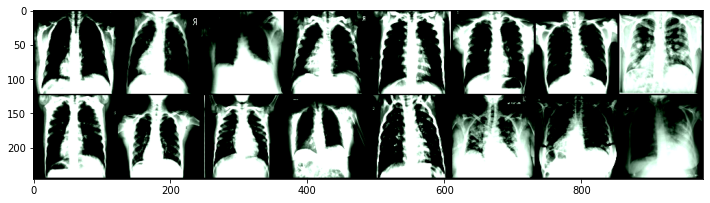

In [16]:
show_img(trainloader)

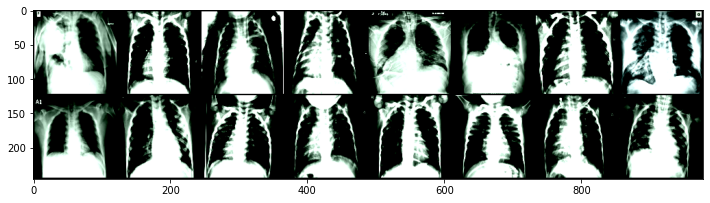

In [17]:
show_img(valloader)

In [18]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [19]:
from torch.nn.modules.linear import Linear
class ANN(nn.Module):
  def __init__(self, hidden_layr= 64):
      super(ANN, self).__init__()

      self.fcl = nn.Linear(120*120*3,hidden_layr)
      self.fc2 = nn.Linear(hidden_layr, 3)

      self.relu = nn.ReLU()

  def forward(self, img):
    out = img.view(-1, 120*120*3)
    out = self.fcl(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out   

In [21]:
model = ANN().to(DEVICE)
print(model.parameters)

<bound method Module.parameters of ANN(
  (fcl): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)>


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.001)

In [26]:
train_accu = [ ]
train_losses = [ ]

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(trainloader):
     
    inputs,labels=data[0].to(DEVICE),data[1].to(DEVICE)
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [27]:
eval_losses=[]
eval_accu=[]
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(valloader):
      images,labels=data[0].to(DEVICE),data[1].to(DEVICE)
       
      outputs=model(images)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
   
  test_loss=running_loss/len(valloader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

In [28]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Train Loss: 0.603 | Accuracy: 77.689


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Test Loss: 0.463 | Accuracy: 82.000

Epoch : 2


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Train Loss: 0.353 | Accuracy: 89.641


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Test Loss: 0.433 | Accuracy: 86.000

Epoch : 3


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Train Loss: 0.296 | Accuracy: 90.837


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Test Loss: 0.361 | Accuracy: 88.000

Epoch : 4


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Train Loss: 0.241 | Accuracy: 91.633


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Test Loss: 0.331 | Accuracy: 84.000

Epoch : 5


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Train Loss: 0.240 | Accuracy: 91.235


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Test Loss: 0.419 | Accuracy: 90.000

Epoch : 6


100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


Train Loss: 0.186 | Accuracy: 94.024


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Test Loss: 0.314 | Accuracy: 86.000

Epoch : 7


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Train Loss: 0.200 | Accuracy: 93.625


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Test Loss: 0.237 | Accuracy: 88.000

Epoch : 8


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Train Loss: 0.171 | Accuracy: 95.219


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Test Loss: 0.404 | Accuracy: 86.000

Epoch : 9


100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


Train Loss: 0.163 | Accuracy: 96.414


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Test Loss: 0.256 | Accuracy: 88.000

Epoch : 10


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Train Loss: 0.144 | Accuracy: 95.618


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Test Loss: 0.227 | Accuracy: 92.000


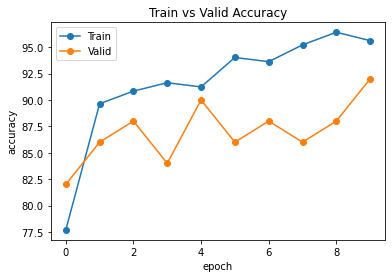

In [29]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

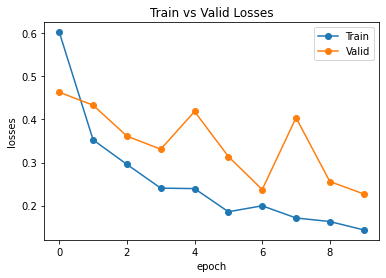

In [30]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [44]:
def predict_img(img, model):
  x = img.unsqueeze(0)
  y = model(x.to(DEVICE))

  Pred = torch.argmax(y, dim=1)

  return train_data.classes[Pred]



Actual Label :  Covid | prediction label:  Covid


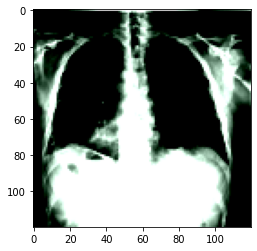

In [70]:
img, label = test_data[2]
plt.imshow(img.permute(1,2,0))
print("Actual Label : ", train_data.classes[label],'|', "prediction label: ",predict_img(img, model) )